<a href="https://colab.research.google.com/github/PadamSharma/Sentiment-Analysis-using-BERT/blob/main/sentiment_analysis_using_albert_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# creating folders to ease formation of text dataset
!mkdir global
!mkdir /content/global/train
!mkdir /content/global/dev.gold
!mkdir /content/global/train/0
!mkdir /content/global/train/1
!mkdir /content/global/train/2
!mkdir /content/global/train/3
!mkdir /content/global/train/4
!mkdir /content/global/dev.gold/0
!mkdir /content/global/dev.gold/1
!mkdir /content/global/dev.gold/2
!mkdir /content/global/dev.gold/3
!mkdir /content/global/dev.gold/4

In [ ]:
#training set
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt

#validation set
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/anger-ratings-0to1.dev.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/fear-ratings-0to1.dev.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/joy-ratings-0to1.dev.gold.txt
!wget http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/sadness-ratings-0to1.dev.gold.txt

In [28]:
emotion_list = ['anger','fear','joy','sadness']
label_dict = {'neutral': '0', 'anger': '1', 'fear': '2', 'joy': '3', 'sadness': '4'}
classNames = {0: 'neutral', 1: 'anger',2: 'fear',3: 'joy',4: 'sadness'}
data_list = ['train','dev.gold']

In [4]:
# creating .txt files in respective folders
count = 0
for data in data_list:
  for emotion in emotion_list:
    File = open('/content/'+emotion+'-ratings-0to1.'+data+'.txt', 'r') 
    lines = File.readlines() 
    for line in lines: 
      line=line.strip()
      l=line.split("\t")
      del(l[0])
      del(l[1])
      if(float(l[1])>(0.35)):
        f=open('/content/global/'+data+'/'+label_dict[emotion]+'/'+str(count)+'.txt',"w")
        f.write(l[0])
        f.close()
      else:
        f=open('/content/global/'+data+'/0/'+str(count)+'.txt',"w")
        f.write(l[0])
        f.close()    
      count+=1

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q -U tf-models-official
!pip install -U tfds-nightly
!pip install tensorflowjs
!pip install tensorflow-text
!pip install tensorflow-io
import os
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [6]:
# importing necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np
import tensorflowjs as tfjs

tf.get_logger().setLevel('ERROR')

In [7]:
# converting text files to tf dataset
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16 * 1
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/global/train',
    batch_size=batch_size,
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/global/dev.gold',
    batch_size=batch_size,
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 3613 files belonging to 5 classes.
Found 347 files belonging to 5 classes.


In [8]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(6):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {class_names[label]}')

Review: b'Lets start there'
Label : 0
Review: b"@obyezeks \\nWe can't forget d past.But while we apprehend and punish d culprits of the past,are we going to allow d present to slip away?"
Label : 2
Review: b'@dfkm1970 @tomddumba the struggle is real. Whoa! I worry for the younger generation \xf0\x9f\x92\x94'
Label : 2
Review: b'#India right of reply at #UNGA - #Pakistan preaching of human rights is by a country which is itself the global epicentre of #terrorism'
Label : 2
Review: b'Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much '
Label : 3
Review: b'jesus ok an alarming percentage of my teachers ths year dont have a  s ingle thoughtful bone in their bodies . its gonna b an interesting yr'
Label : 2


In [9]:
# selecting the required BERT model
bert_model_name = 'albert_en_base'

map_name_to_handle = {
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2'
}

map_model_to_preprocess = {
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocessing model auto-selected: {tfhub_handle_preprocess}')

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/2
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)


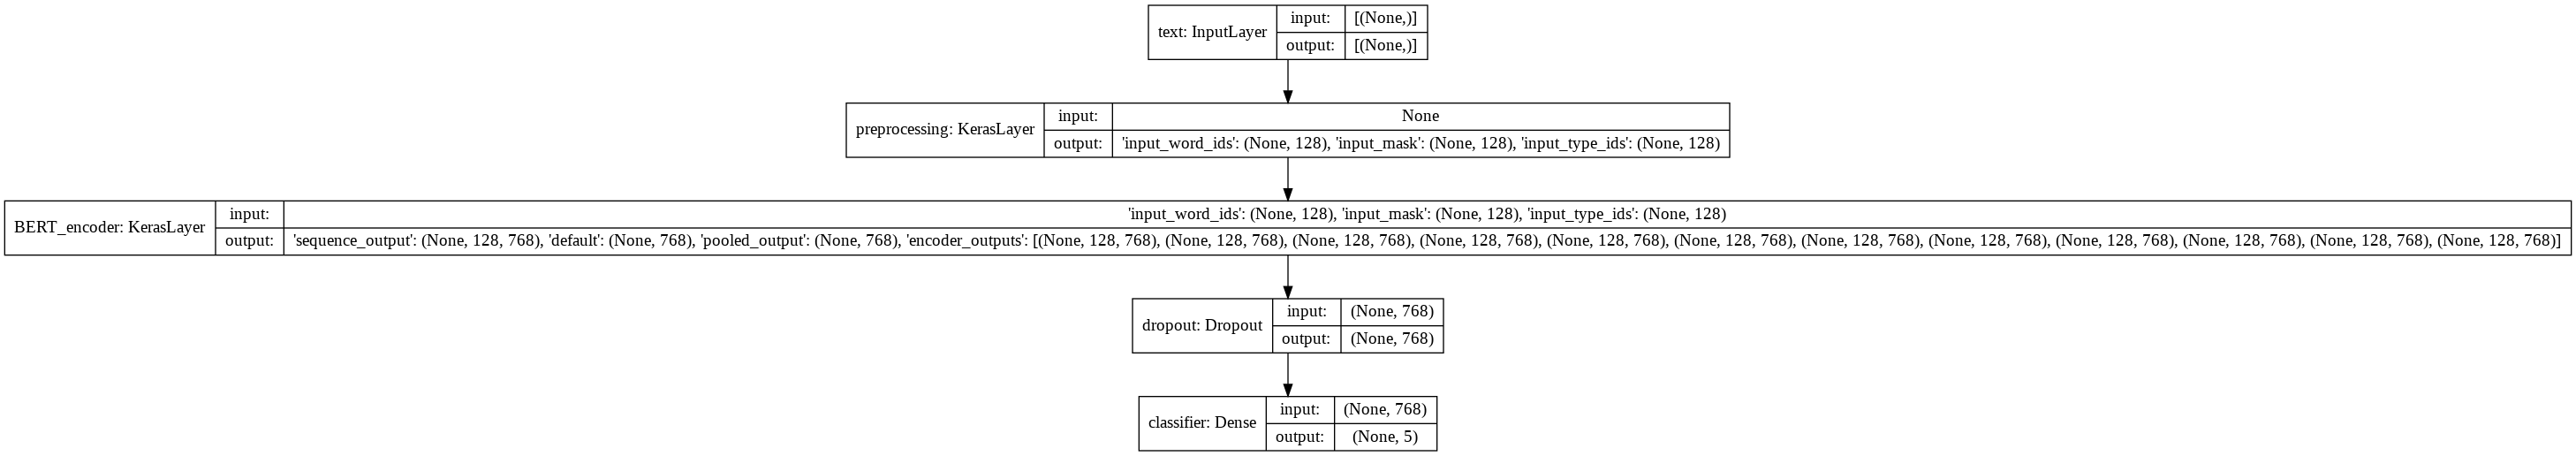

In [11]:
# building and plotting the model
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model, show_shapes=True)

In [12]:
# specifying loss and metrics 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.metrics.SparseCategoricalAccuracy()

In [13]:
epochs = 8
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [15]:
print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)


Training model with https://tfhub.dev/tensorflow/albert_en_base/2
Epoch 1/8
226/226 [==============================] - 140s 561ms/step - loss: 1.7152 - sparse_categorical_accuracy: 0.2441 - val_loss: 1.3231 - val_sparse_categorical_accuracy: 0.4813
Epoch 2/8
226/226 [==============================] - 126s 557ms/step - loss: 1.1779 - sparse_categorical_accuracy: 0.5096 - val_loss: 0.9428 - val_sparse_categorical_accuracy: 0.6513
Epoch 3/8
226/226 [==============================] - 126s 557ms/step - loss: 0.7498 - sparse_categorical_accuracy: 0.7072 - val_loss: 1.0523 - val_sparse_categorical_accuracy: 0.6455
Epoch 4/8
226/226 [==============================] - 126s 557ms/step - loss: 0.5291 - sparse_categorical_accuracy: 0.8058 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.6628
Epoch 5/8
226/226 [==============================] - 126s 557ms/step - loss: 0.3302 - sparse_categorical_accuracy: 0.8782 - val_loss: 1.3162 - val_sparse_categorical_accuracy: 0.6715
Epoch 6/8
226/226 [

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


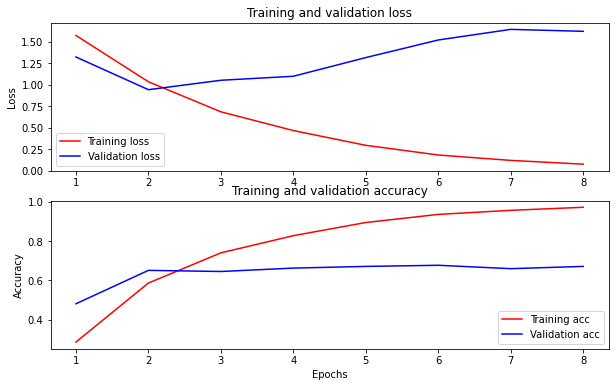

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [ ]:
saved_model_path = 'sentiment_analysis_using_bert'
classifier_model.save(saved_model_path)

saved_model_path1 = 'sentiment_analysis_using_bert.h5'
classifier_model.save(saved_model_path)

In [31]:
import numpy as np
def print_my_examples(inputs, results):
  rslt_in_words = []
  for i in range(len(inputs)):
    rslt = np.argmax(results[i])
    rslt_in_words.append(classNames[rslt])
  result_for_printing = \
    [f'input: {inputs[i]:<30} :\n score: {rslt_in_words[i]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

examples = [
            'Today I encountered a very sad event in my life.',
            'I have the sheer will to do anything I want.',
            'After seeing a ghostly figure outside of my window I shouted in fright!',
            'Why are you threatening me? What harm do I have caused you ? Back off or I will hit you in the face!'

]

original_results = (classifier_model(tf.constant(examples)))

print('Results from the classifier model:')
print_my_examples(examples, original_results)


Results from the classifier model:
input: Today I encountered a very sad event in my life. :
 score: sadness
input: I have the sheer will to do anything I want. :
 score: neutral
input: After seeing a ghostly figure outside of my window I shouted in fright! :
 score: fear
input: Why are you threatening me? What harm do I have caused you ? Back off or I will hit you in the face! :
 score: anger

